In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from nuclear_matter.stats_utils import *
from nuclear_matter.matter import *
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
import seaborn as sns
import time
from itertools import product
from tqdm import tqdm

%matplotlib inline

In [2]:
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['figure.dpi'] = 150
# mpl.rcParams['font.family'] = 'serif'
# mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')
setup_rc_params()

In [3]:
# Lambda = 450
Lambda = 500

high_density = True
# if high_density:
#     filename = '../data/all_matter_data_high_density.csv'
# else:
#     filename = '../data/all_matter_data.csv'
    
# data = InputData(filename, Lambda, high_density)

filename_low = '../data/all_matter_data.csv'
# filename_high = '../data/all_matter_data_high_density.csv'
filename_high = '../data/all_matter_data_high_density_smooth.csv'
    
data_high_density = InputData(filename_high, Lambda)
data_low_density = InputData(filename_low, Lambda)

if high_density:
    data = data_high_density
else:
    data = data_low_density

In [4]:
orders = np.array([0, 2, 3, 4])
# orders_appended = np.array([0, 2, 3, 4, 3, 4])
orders_appended = np.array([0, 2, 3, 3, 4, 4])

body2 = 'NN-only'
body23 = 'NN+3N'
body3 = '3N'
body23_appended = 'Appended'

pure_neutron = 'pure'
sym_nuclear = 'sym'
# avg_momentum = 'avg'
s2_energy = 's2'

train = slice(None, None, 4)
valid = slice(2, None, 4)


excluded_2bf = np.array([0, 1])
# excluded_2bf = np.array([1])
excluded_3bf = np.array([0, 1, 2])

savefigs = False

Lb = 600

breakdown_min = 300
breakdown_max = 1000
breakdown_num = 100
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

ls_min = 0.1
ls_max = 1.5
ls_num = 50
ls_vals = np.linspace(ls_min, ls_max, ls_num)
# ls_min = ls_max = ls_num = ls_vals = None


# The Gaussian process parameters
nugget = 1e-6

kernel = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel_theta = kernel.theta
ref_2bf = 16

hyperparams = dict(
    center=0,
    disp=0,
    df=0,
    scale=1,
)

# optimizer = None



In [5]:
fermi_momentum(0.16, 2)

1.679501235221182

In [6]:
fermi_momentum(0.16, 4)

1.3330210137859975

In [7]:
kf_n = data.kf_n
Kf_n = data.Kf_n
kf_s = data.kf_s
Kf_s = data.Kf_s
kf_d = data.kf_avg
Kf_d = data.Kf_avg

density = data.density

y_s_2_plus_3bf = data.y_s_2_plus_3bf
y_n_2_plus_3bf = data.y_n_2_plus_3bf
y_d_2_plus_3bf = data.y_d_2_plus_3bf

y_s_2bf = data.y_s_2bf
y_n_2bf = data.y_n_2bf
y_d_2bf = data.y_d_2bf

y_s_3bf = data.y_s_3bf
y_n_3bf = data.y_n_3bf
y_d_3bf = data.y_d_3bf

fit_n2lo = data.fit_n2lo
fit_n3lo = data.fit_n3lo

In [8]:
from nuclear_matter.matter import ratio_density

In [9]:
Q_n = ratio_kf(data.Kf_n, breakdown=Lb)
Q_s = ratio_kf(data.Kf_s, breakdown=Lb)
Q_d = ratio_kf(data.Kf_avg, breakdown=Lb)

# Lb_rho = 40
# Q_n_rho = ratio_kf(data.density, breakdown=Lb_rho)
# Q_s_rho = ratio_kf(data.density, breakdown=Lb_rho)
# Q_d = ratio_kf(Kf_d, breakdown=Lb)

In [10]:
(kf_n / fermi_momentum(0.16, 2))**2

array([0.46050641, 0.52002098, 0.57630568, 0.62995957, 0.68142246,
       0.73100102, 0.77896406, 0.82548382, 0.87072828, 0.91483196,
       0.95789115, 0.99999853, 1.0412489 , 1.0816851 , 1.12139045,
       1.16039995, 1.1987592 , 1.23652364, 1.27371767, 1.31037208,
       1.34652369, 1.38218704, 1.41740903, 1.45219865, 1.48656783,
       1.52054593, 1.55415075, 1.58740261, 1.62030909, 1.65287944])

In [11]:
(kf_s / fermi_momentum(0.16, 4))**2

array([0.46049994, 0.5200161 , 0.57630542, 0.62996114, 0.68141452,
       0.73100837, 0.77896376, 0.82548186, 0.87072894, 0.91482825,
       0.95788649, 0.99999848, 1.04123967, 1.08169073, 1.12138686,
       1.16039178, 1.19876542, 1.23652837, 1.2737083 , 1.31037389,
       1.34651496, 1.38219498, 1.41741257, 1.45220522, 1.48657812,
       1.52055742, 1.55415372, 1.58739872, 1.62030793, 1.65287959])

In [12]:
# ref_n_2bf = ref_s_2bf = ref_d_2bf = data.ref_2bf

# ref_n_2bf = data.ref_2bf * kf_n**2
# ref_s_2bf = data.ref_2bf * kf_s**2
# ref_d_2bf = data.ref_2bf * kf_d**2

ref_n_2bf = data.ref_2bf * (kf_n / fermi_momentum(0.16, 2))**2
ref_s_2bf = data.ref_2bf * (kf_s / fermi_momentum(0.16, 4))**2
ref_d_2bf = data.ref_2bf * (kf_d / fermi_momentum(0.16, 2))**2

# ref_n_2bf = 8 * (kf_n)**2
# ref_s_2bf = 8 * (kf_s)**2
# ref_d_2bf = 8 * (kf_d)**2



# ref_n_3bf = data.ref_n_3bf / kf_n**2
# ref_s_3bf = data.ref_s_3bf / kf_s**2
# ref_d_3bf = data.ref_avg_3bf / kf_d**2

# ref_n_3bf = data.ref_n_3bf / kf_n**3 * (kf_n / fermi_momentum(0.16, 2))**3
# ref_s_3bf = data.ref_s_3bf / kf_s**3 * (kf_s / fermi_momentum(0.16, 4))**3
# ref_d_3bf = data.ref_avg_3bf / kf_d**3 * (kf_d / fermi_momentum(0.16, 2))**3

# ref_n_3bf = data.ref_n_3bf / kf_n**3 * (kf_n / fermi_momentum(0.16, 2))**3
# ref_s_3bf = data.ref_s_3bf / kf_s**3 * (kf_s / fermi_momentum(0.16, 4))**3
# ref_d_3bf = data.ref_avg_3bf / kf_d**3 * (kf_d / fermi_momentum(0.16, 2))**3

# ref_n_3bf = data.ref_2bf * (kf_n / fermi_momentum(0.16, 2))**1
# ref_s_3bf = data.ref_2bf * (kf_s / fermi_momentum(0.16, 4))**1
# ref_d_3bf = data.ref_2bf * (kf_d / fermi_momentum(0.16, 2))**1

# ref_n_3bf = data.ref_2bf * (kf_n / fermi_momentum(0.16, 2))**2
# ref_s_3bf = data.ref_2bf * (kf_s / fermi_momentum(0.16, 4))**2
# ref_d_3bf = data.ref_2bf * (kf_d / fermi_momentum(0.16, 2))**2

# ref_n_3bf = data.ref_2bf * (kf_n / fermi_momentum(0.16, 2))**3
# ref_s_3bf = data.ref_2bf * (kf_s / fermi_momentum(0.16, 4))**3
# ref_d_3bf = data.ref_2bf * (kf_d / fermi_momentum(0.16, 2))**3


# ref_n_3bf = data.ref_2bf * (kf_n)**3
# ref_s_3bf = data.ref_2bf * (kf_s)**3
# ref_d_3bf = data.ref_2bf * (kf_d)**3

ref_n_3bf = data.ref_2bf * (kf_n)**2 * 2
ref_s_3bf = data.ref_2bf * (kf_s)**2 * 2
ref_d_3bf = data.ref_2bf * (kf_d)**2 * 2

# ref_n_3bf = ref_2bf * Q_n**1
# ref_s_3bf = ref_2bf * Q_s**1
# ref_d_3bf = ref_2bf * Q_d**1

# ref_n_3bf = data.ref_n_3bf
# ref_s_3bf = data.ref_s_3bf
# ref_d_3bf = data.ref_avg_3bf

In [13]:
def concatenate_2bf_and_3bf_coefficients(c2, c3):
    return np.concatenate([c2[:, :-1], c3[:, [2]], c2[:, [-1]], c3[:, [3]]], axis=1)

In [14]:
coeffs_s_2_plus_3bf = gm.coefficients(y_s_2_plus_3bf, Q_s, ref_s_2bf, orders=orders)
coeffs_n_2_plus_3bf = gm.coefficients(y_n_2_plus_3bf, Q_n, ref_n_2bf, orders=orders)
coeffs_d_2_plus_3bf = gm.coefficients(y_d_2_plus_3bf, Q_d, ref_d_2bf, orders=orders)

coeffs_n_2bf = gm.coefficients(y_n_2bf, Q_n, ref_n_2bf, orders=orders)
coeffs_s_2bf = gm.coefficients(y_s_2bf, Q_s, ref_s_2bf, orders=orders)
coeffs_d_2bf = gm.coefficients(y_d_2bf, Q_d, ref_d_2bf, orders=orders)

coeffs_n_3bf = gm.coefficients(y_n_3bf, Q_n, ref_n_3bf, orders=orders)
coeffs_s_3bf = gm.coefficients(y_s_3bf, Q_s, ref_s_3bf, orders=orders)
coeffs_d_3bf = gm.coefficients(y_d_3bf, Q_d, ref_d_3bf, orders=orders)


coeffs_n_appended = concatenate_2bf_and_3bf_coefficients(coeffs_n_2bf, coeffs_n_3bf)
coeffs_s_appended = concatenate_2bf_and_3bf_coefficients(coeffs_s_2bf, coeffs_s_3bf)
coeffs_d_appended = concatenate_2bf_and_3bf_coefficients(coeffs_d_2bf, coeffs_d_3bf)

y_n_appended = gm.partials(coeffs_n_appended, ratio=Q_n[:, None], ref=ref_n_2bf, orders=orders_appended)
y_s_appended = gm.partials(coeffs_s_appended, ratio=Q_s[:, None], ref=ref_s_2bf, orders=orders_appended)
y_d_appended = gm.partials(coeffs_d_appended, ratio=Q_d[:, None], ref=ref_d_2bf, orders=orders_appended)

# coeffs_n_2_plus_3bf = gm.coefficients(y_n_2_plus_3bf, Q_n_rho, ref_2bf, orders=orders)
# coeffs_s_2_plus_3bf = gm.coefficients(y_s_2_plus_3bf, Q_s_rho, ref_2bf, orders=orders)
# # coeffs_d_2_plus_3bf = gm.coefficients(y_d_2_plus_3bf, Q_d, ref_2bf, orders=orders)

# coeffs_n_2bf = gm.coefficients(y_n_2bf, Q_n_rho, ref_2bf, orders=orders)
# coeffs_s_2bf = gm.coefficients(y_s_2bf, Q_s_rho, ref_2bf, orders=orders)
# # coeffs_d_2bf = gm.coefficients(y_d_2bf, Q_d, ref_2bf, orders=orders)

# coeffs_n_3bf = gm.coefficients(y_n_3bf, Q_n_rho, ref_n_3bf_vals, orders=orders)
# coeffs_s_3bf = gm.coefficients(y_s_3bf, Q_s_rho, ref_s_3bf_vals, orders=orders)
# # coeffs_d_3bf = gm.coefficients(y_d_3bf, Q_d, ref_d_3bf, orders=orders)

Text(0.5, 0, '$n$ [fm$^{-3}$]')

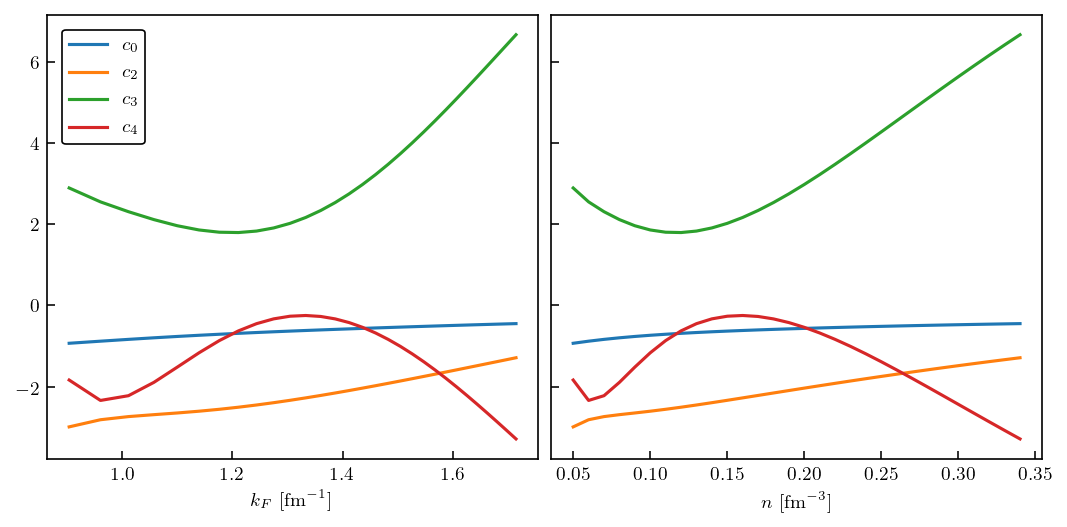

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.4), sharey=True)
for i, n in enumerate(orders):
    axes[0].plot(kf_s, coeffs_s_2_plus_3bf[:, i], label=fr'$c_{n}$')
    axes[1].plot(density, coeffs_s_2_plus_3bf[:, i])
axes[0].legend()
axes[0].set_xlabel(r'$k_F$ [fm$^{-1}$]')
axes[1].set_xlabel(r'$n$ [fm$^{-3}$]')

In [16]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]

In [17]:
# use_kf = True

kf_x_label = r'$k_F$ [fm$^{-1}$]'
density_x_label = r'$\rho$ [fm$^{-3}$]'

# if use_kf:
#     x_n = kf_n
#     x_s = kf_s
#     x_d = kf_d
#     x_label = kf_x_label
#     x_save = 'use-kf'
# else:
#     x_n = x_s = x_d = density
#     x_label = density_x_label
    
#     x_save = 'use-rho'

In [18]:
def plot_coefficients(kf, d, coeffs_2bf, coeffs_3bf, coeffs_23bf, orders, colors):
    fig, axes = plt.subplots(2, 2, figsize=(7, 4.5), sharey=True, sharex='col')
    for i, n in enumerate(orders):

        axes[0, 0].plot(kf, coeffs_23bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2+3)}}$')
        axes[0, 0].plot(kf[train], coeffs_23bf[train, i], c=colors[i], ls='', marker='o')
        axes[1, 0].plot(kf, coeffs_2bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2)}}$')
        if n > 2:
            axes[1, 0].plot(kf, coeffs_3bf[:, i], c=colors[i], ls='--', label=fr'$c_{n}^{{(3)}}$')

        axes[0, 1].plot(d, coeffs_23bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2+3)}}$')
        axes[1, 1].plot(d, coeffs_2bf[:, i], c=colors[i], label=fr'$c_{n}^{{(2)}}$')
        if n > 2:
            axes[1, 1].plot(d, coeffs_3bf[:, i], c=colors[i], ls='--', label=fr'$c_{n}^{{(3)}}$')

    for ax in axes.ravel():
        ax.axhline(0, 0, 1, c='lightgrey', zorder=0)
        ax.tick_params(direction='in')
    axes[1, 0].set_xlabel(kf_x_label)
    axes[1, 1].set_xlabel(density_x_label)
    axes[0, 0].legend(ncol=2)
    axes[1, 0].legend(ncol=3)
    
    ylim_top = np.max(np.abs(axes[0,0].get_ylim()))
    axes[0, 0].set_ylim(-ylim_top, ylim_top)
    
    ylim_bot = np.max(np.abs(axes[1,0].get_ylim()))
    axes[1, 0].set_ylim(-ylim_bot, ylim_bot)
#     fig.tight_layout(h_pad=0.3, w_pad=0.3)
    return fig, axes

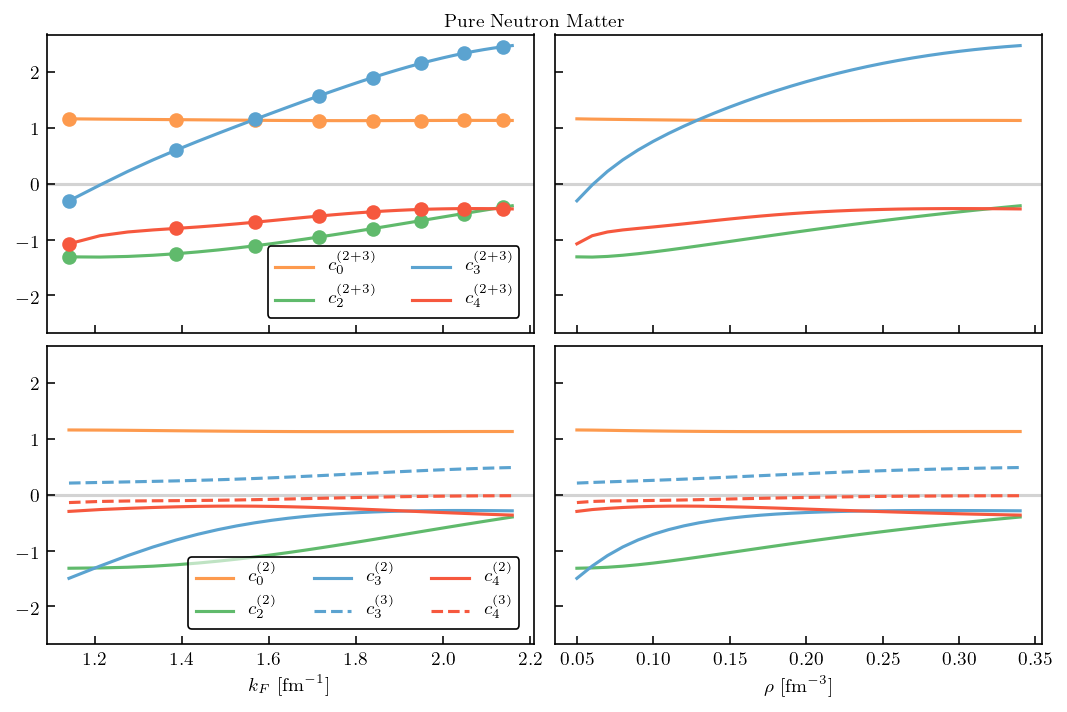

In [19]:
fig, axes = plot_coefficients(
    kf_n, density, coeffs_2bf=coeffs_n_2bf, coeffs_3bf=coeffs_n_3bf,
    coeffs_23bf=coeffs_n_2_plus_3bf, orders=orders, colors=colors)
fig.suptitle('Pure Neutron Matter', y=1.02)

fig.savefig(f'coeffs_neutron_matter_compare_2bf_3bf')

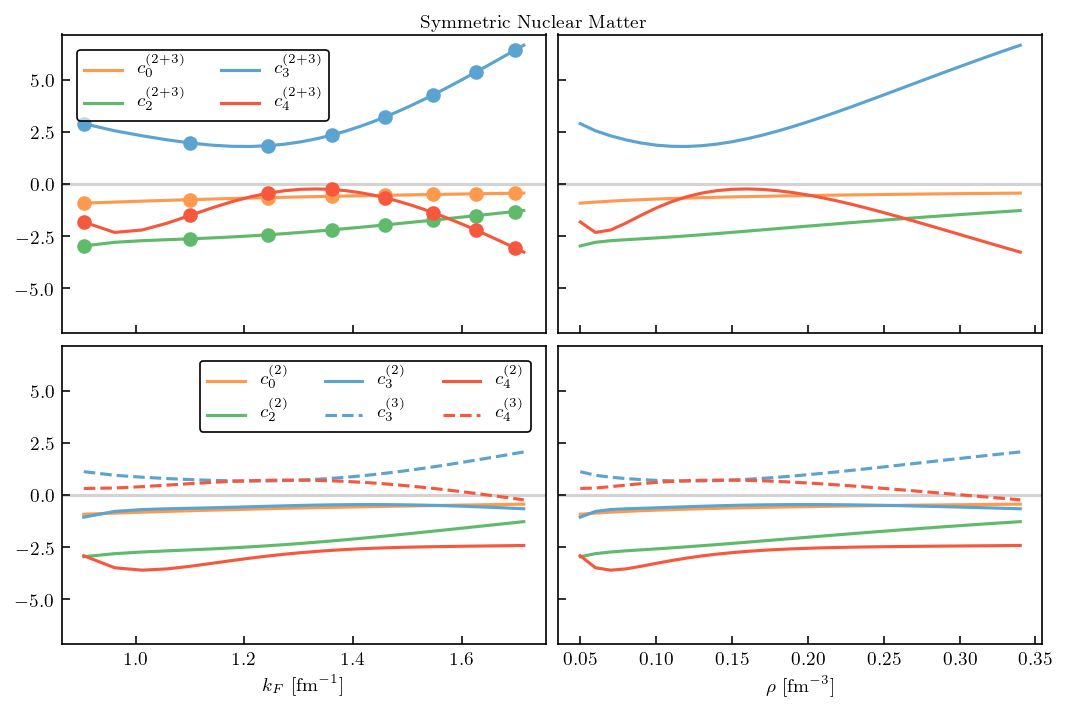

In [20]:
fig, axes = plot_coefficients(
    kf_s, density, coeffs_2bf=coeffs_s_2bf, coeffs_3bf=coeffs_s_3bf,
    coeffs_23bf=coeffs_s_2_plus_3bf, orders=orders, colors=colors)
fig.suptitle('Symmetric Nuclear Matter', y=1.02)
fig.savefig(f'coeffs_nuclear_matter_compare_2bf_3bf')

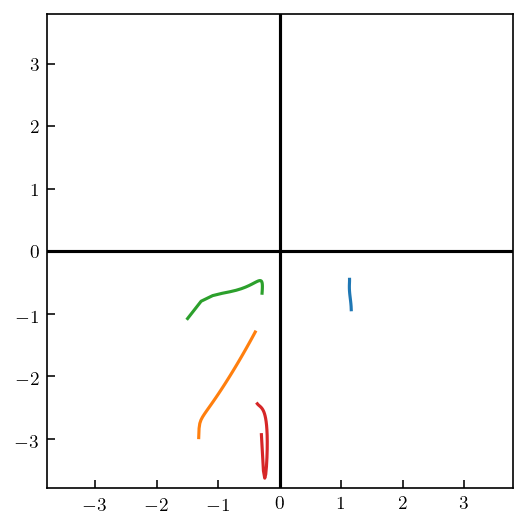

In [21]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
for i, n in enumerate(orders):
    ax.plot(coeffs_n_2bf[:, i], coeffs_s_2bf[:, i])
    
lim_max = np.max(np.abs([*ax.get_ylim(), *ax.get_xlim()]))
ax.set_xlim(-lim_max, lim_max)
ax.set_ylim(-lim_max, lim_max)
ax.axvline(0, 0, 1, c='k')
ax.axhline(0, 0, 1, c='k')

In [22]:
orders

array([0, 2, 3, 4])

In [23]:
from nuclear_matter import confidence_ellipse

In [24]:
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import MinCovDet

Pearson correlation: 0.9433155267037199


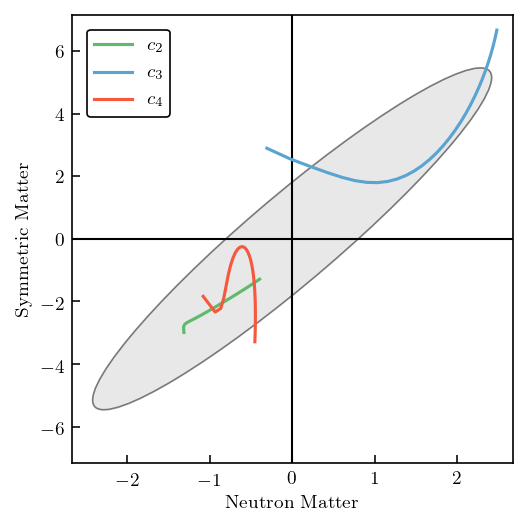

In [102]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))

# c_n_std = np.std([coeffs_n_2bf, coeffs_n_3bf])
# c_s_std = np.std([coeffs_s_2bf, coeffs_s_3bf])
c_n_std = c_s_std = 1


# cn_flat = np.concatenate((coeffs_n_2bf.ravel()/c_n_std, coeffs_n_3bf.ravel()/c_n_std))
# cs_flat = np.concatenate((coeffs_s_2bf.ravel()/c_s_std, coeffs_s_3bf.ravel()/c_s_std))

cn_set = []
cs_set = []

for i, n in enumerate(orders):
    if n == 0:
        continue
    ax.plot(
        coeffs_n_2_plus_3bf[:, i]/c_n_std, coeffs_s_2_plus_3bf[:, i]/c_s_std,
        c=colors[i], label=f'$c_{n}$', zorder=5,
    )
    cn_set.append(coeffs_n_2_plus_3bf[:, i]/c_n_std)
    cs_set.append(coeffs_s_2_plus_3bf[:, i]/c_s_std)
#     if n > 2:
#         ax.plot(coeffs_n_3bf[:, i]/c_n_std, coeffs_s_3bf[:, i]/c_s_std, c=colors[i], ls='--', label=f'$c_{n}^{{(3)}}$')
#         cn_set.append(coeffs_n_3bf[:, i]/c_n_std)
#         cs_set.append(coeffs_s_3bf[:, i]/c_s_std)

cn_set = np.array(cn_set)
cs_set = np.array(cs_set)
cn_flat = cn_set.ravel()
cs_flat = cs_set.ravel()
c_both_flat = np.stack((cn_flat, cs_flat), axis=0).T

# Don't center the observations, assume zero mean:
mean_ns = np.zeros(c_both_flat.shape[0])
cov_ns = c_both_flat.T @ c_both_flat / (len(c_both_flat) - 1)

# cov_ns_big = c_both_flat @ c_both_flat.T / (c_both_flat.shape[-1] - 1)
pearson = cov_ns[1, 0] / np.sqrt(cov_ns[0, 0] * cov_ns[1, 1])
print('Pearson correlation:', pearson)

confidence_ellipse_mean_cov(mean_ns, cov_ns, ax, n_std=2, facecolor='lightgrey', edgecolor='k', alpha=0.5, zorder=-2)
# confidence_ellipse(cn_flat, cs_flat, ax, n_std=2, facecolor='lightgrey', edgecolor='k', alpha=0.5, zorder=-2, show_scatter=True)
ylim_max = 1.0 * np.max(np.abs(ax.get_ylim()))
xlim_max = 1.0 * np.max(np.abs(ax.get_xlim()))
ax.set_xlabel('Neutron Matter')
ax.set_ylabel('Symmetric Matter')
ax.set_xlim(-xlim_max, xlim_max)
ax.set_ylim(-ylim_max, ylim_max)
ax.legend(loc='upper left')
ax.axvline(0, 0, 1, c='k', zorder=-1, lw=1)
ax.axhline(0, 0, 1, c='k', zorder=-1, lw=1);
fig.savefig(f'manuscript_figures/empirical_correlation_ellipse_coefficients_Lambda-{Lambda}')

In [26]:
cov_ns.shape

(2, 2)

In [27]:
cn_set.shape[0]

3

In [118]:
from nuclear_matter.stats_utils import cov_no_centering

In [119]:
cn_set.shape

(3, 30)

In [84]:
# cov_ns_offdiag = cn_set.T @ cs_set / (cn_set.shape[0] - 1)
# cov_ns_full = cov_no_centering(cn_set.T / np.max(np.abs(cn_set)), cs_set.T / np.max(np.abs(cs_set)))
cov_ns_full = cov_no_centering(cn_set.T, cs_set.T)
# cov_ns_full = np.cov(cn_set.T, cs_set.T)
# cov_ns_full = np.cov(cn_set.T / np.max(np.abs(cn_set)), cs_set.T / np.max(np.abs(cs_set)))
cov_ns_offdiag = cov_ns_full[:30, 30:]

cov_ns_offdiag_norm = cov_ns_offdiag / np.sqrt(cov_ns_full[30:,30:] * cov_ns_full[:30,:30])
cov_ns_full_norm = cov_ns_full / np.sqrt(np.diag(cov_ns_full) * np.diag(cov_ns_full)[:, None])
corr_ns_full = cov_ns_full / np.sqrt(np.diag(cov_ns_full) * np.diag(cov_ns_full)[:, None])

/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  func(*args, **kwargs)
/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


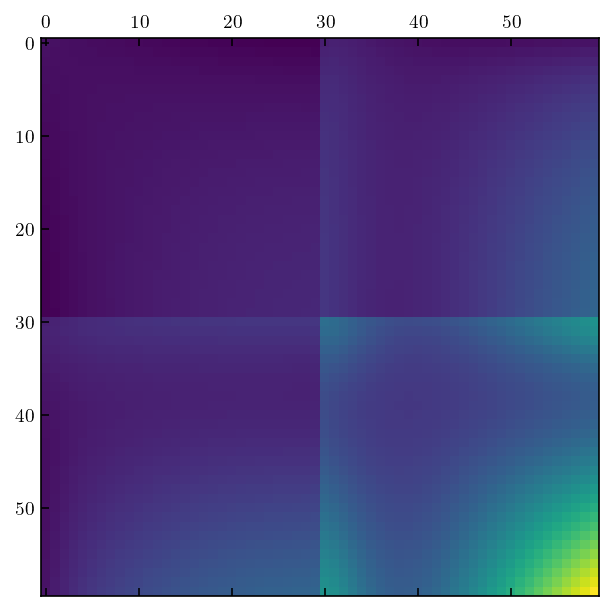

In [85]:
plt.matshow(cov_ns_full)

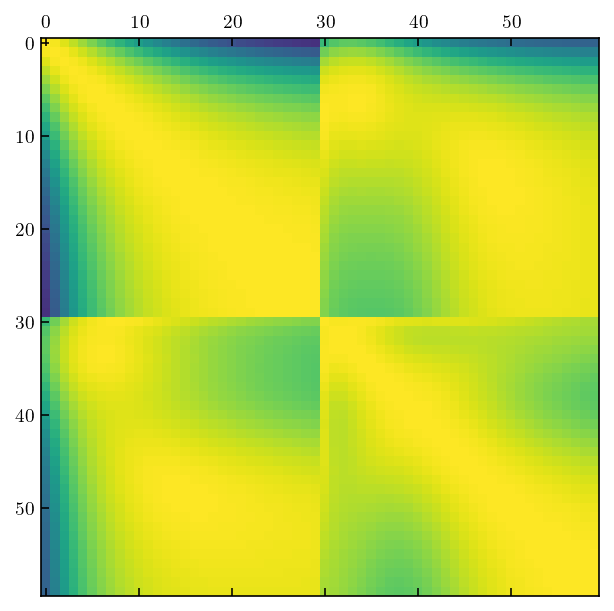

In [94]:
plt.matshow(cov_ns_full_norm, vmin=-0.1)

In [32]:
np.mean(cov_ns_offdiag_norm)

1.0490279098582962

In [33]:
cov_ns_offdiag_norm

array([[0.63942968, 0.73257902, 0.75586045, 0.74971224, 0.73073623,
        0.7062886 , 0.67998934, 0.6538358 , 0.6291763 , 0.60707171,
        0.5883745 , 0.57375123, 0.5636859 , 0.55844246, 0.55817658,
        0.56288317, 0.57250192, 0.58697069, 0.60621128, 0.63018192,
        0.6589188 , 0.69251117, 0.73117922, 0.77522684, 0.82509874,
        0.88144643, 0.94514348, 1.01739386, 1.09981723, 1.19466077],
       [0.75304794, 0.81029094, 0.81760482, 0.80549562, 0.78604955,
        0.76432065, 0.74257346, 0.72190767, 0.70301007, 0.6864398 ,
        0.67268187, 0.66213755, 0.65509145, 0.6516563 , 0.65182976,
        0.65545657, 0.6623033 , 0.6720969 , 0.68452557, 0.69927929,
        0.71606569, 0.7346069 , 0.75466003, 0.77599684, 0.79841088,
        0.82173144, 0.84580195, 0.87049265, 0.89568194, 0.92125969],
       [0.87817954, 0.91055421, 0.90166699, 0.87851475, 0.85158593,
        0.82508374, 0.80075855, 0.77934061, 0.76117872, 0.74648681,
        0.73540051, 0.7279842 , 0.72421806, 0.

In [34]:
cov_ns_full.shape

(60, 60)

In [35]:
cov_ns_full

array([[ 1.48547688,  1.36638524,  1.28540607, ...,  1.5092508 ,
         1.55284056,  1.59652544],
       [ 1.36638524,  1.29827132,  1.25684475, ...,  2.17983496,
         2.24434582,  2.30838923],
       [ 1.28540607,  1.25684475,  1.24754471, ...,  2.82860428,
         2.91760803,  3.00558264],
       ...,
       [ 1.5092508 ,  2.17983496,  2.82860428, ..., 24.08095236,
        25.14344523, 26.18694065],
       [ 1.55284056,  2.24434582,  2.91760803, ..., 25.14344523,
        26.26260987, 27.36182174],
       [ 1.59652544,  2.30838923,  3.00558264, ..., 26.18694065,
        27.36182174, 28.5158119 ]])

In [36]:
cov_ns_full.min()

0.12216603939562792

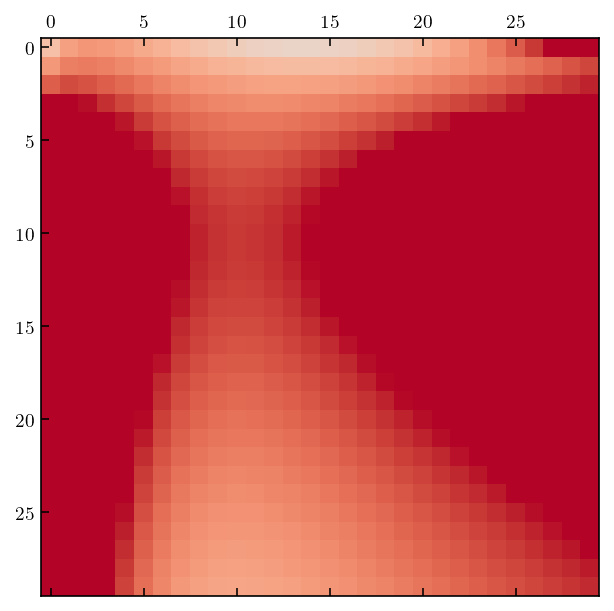

In [37]:
plt.matshow(cov_ns_offdiag_norm, cmap='coolwarm', vmin=0, vmax=1)

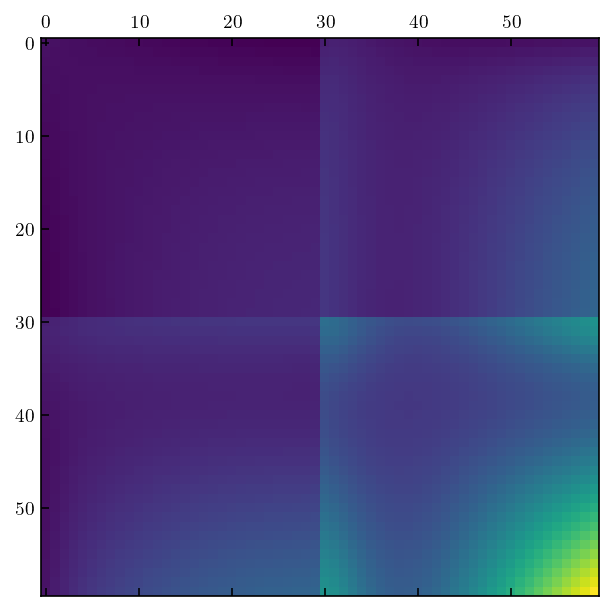

In [38]:
plt.matshow(
    cov_ns_full,
#     vmin=0, vmax=1
)

In [39]:
from matplotlib.colors import LogNorm

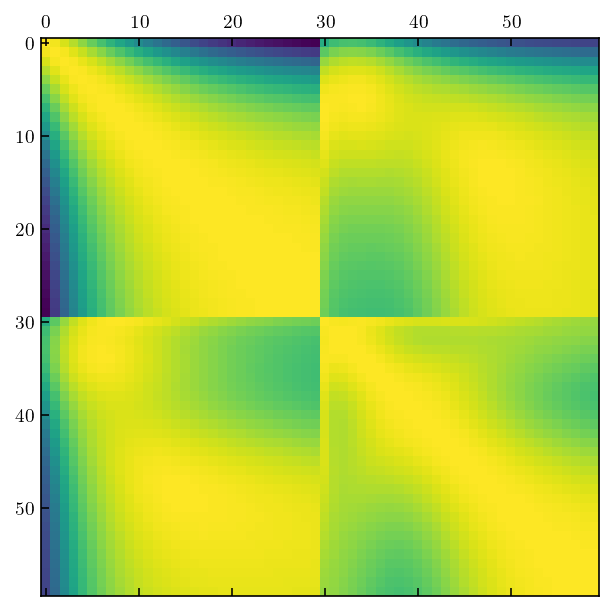

In [40]:
plt.matshow(
    cov_ns_full / np.sqrt(np.diag(cov_ns_full) * np.diag(cov_ns_full)[:, None]),
#     norm=LogNorm(vmin=0.7, vmax=1)
)

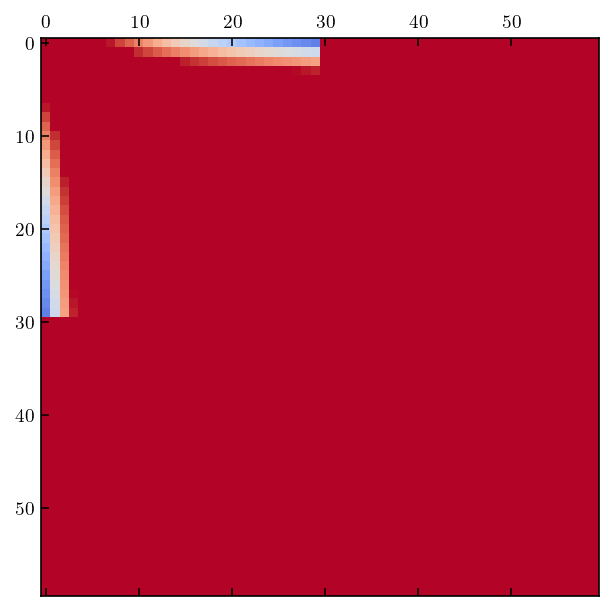

In [41]:
plt.matshow(cov_ns_full, cmap='coolwarm', vmin=0, vmax=1)

In [42]:
cn_set.shape

(3, 30)

In [43]:
c_both_flat.shape

(90, 2)

In [45]:
cov_ns_offdiag

array([[2.50894868, 2.71701005, 2.64034995, 2.46187445, 2.25543432,
        2.05289714, 1.86822613, 1.70680341, 1.56990043, 1.45682358,
        1.3659041 , 1.29506477, 1.24213576, 1.20498071, 1.18162302,
        1.17021376, 1.16909169, 1.17676869, 1.19190727, 1.21334547,
        1.24001991, 1.27103993, 1.30557857, 1.34294274, 1.38249622,
        1.42370473, 1.46608684, 1.5092508 , 1.55284056, 1.59652544],
       [2.79292577, 2.91532564, 2.81258909, 2.63022685, 2.42953419,
        2.23775432, 2.06697309, 1.92171639, 1.80279203, 1.70919261,
        1.63900299, 1.58993438, 1.55962265, 1.54576243, 1.54620181,
        1.55895158, 1.58222674, 1.61440723, 1.65404317, 1.6999021 ,
        1.75081116, 1.80583149, 1.86405535, 1.92474493, 1.98720652,
        2.05087041, 2.11521662, 2.17983496, 2.24434582, 2.30838923],
       [3.06763145, 3.13233824, 3.00439166, 2.80952721, 2.60320552,
        2.41077419, 2.24355975, 2.10563435, 1.99742405, 1.91754706,
        1.86371782, 1.83328977, 1.82355688, 1.

In [120]:
ls1_test = 0.53
ls2_test = 0.3
k1 = RBF(ls1_test)# + WhiteKernel(1e-4)
k2 = RBF(ls2_test)# + WhiteKernel(1e-4)

rho_test = 0.1
# k_off = ConstantKernel(rho_test)# * RBF(0.9) + WhiteKernel(1e-4)
k_off = RBF(np.sqrt((ls1_test**2 + ls2_test**2)/2))
N_test = 101
x_test = np.linspace(0, 1, N_test)
X_test = x_test[:, None]
mean_test = np.zeros(2*N_test)

prefactor_test = np.sqrt(2 * ls1_test * ls2_test / (ls1_test**2 + ls2_test**2))
print(prefactor_test)
K_off = prefactor_test * k_off(X_test)
# K_off = np.zeros((N_test, N_test))

cov_test = np.block([
    [k1(X_test), K_off],
    [K_off, k2(X_test)],
])
cov_test += 1e-7 * np.eye(cov_test.shape[0])

np.random.seed(3)
mvn_test = stats.multivariate_normal(mean_test, cov_test)

samples_test = mvn_test.rvs(10).T
samples1_test = samples_test[:N_test]
samples2_test = samples_test[N_test:]

0.9259448986003439


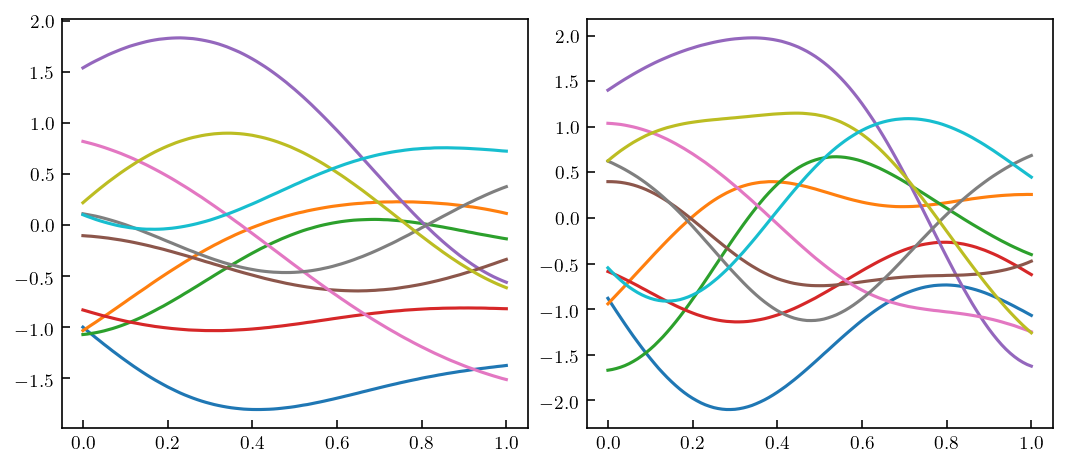

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
axes[0].plot(x_test, samples1_test);
axes[1].plot(x_test, samples2_test);

In [122]:
samples_test.shape

(202, 10)

Pearson correlation: 0.914555376325949


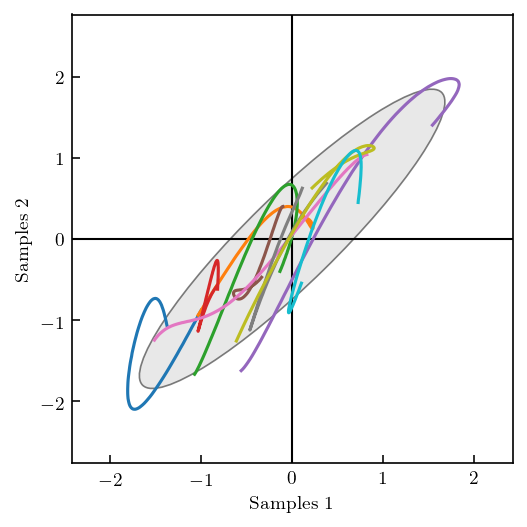

In [123]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax.plot(samples1_test, samples2_test);

samples_test_flat = np.stack((samples1_test.ravel(), samples2_test.ravel())).T
# Don't center the observations, assume zero mean:
mean_samples = np.zeros(samples_test_flat.shape[1])
cov_samples = samples_test_flat.T @ samples_test_flat / (samples_test_flat.shape[0] - 1)

# cov_ns_big = c_both_flat @ c_both_flat.T / (c_both_flat.shape[-1] - 1)
pearson_samples = cov_samples[1, 0] / np.sqrt(cov_samples[0, 0] * cov_samples[1, 1])
print('Pearson correlation:', pearson_samples)

confidence_ellipse_mean_cov(
    mean_samples, cov_samples, ax, n_std=2,
    facecolor='lightgrey', edgecolor='k', alpha=0.5, zorder=-2
)
# confidence_ellipse(cn_flat, cs_flat, ax, n_std=2, facecolor='lightgrey', edgecolor='k', alpha=0.5, zorder=-2, show_scatter=True)
ylim_max = 1.2 * np.max(np.abs(ax.get_ylim()))
xlim_max = 1.2 * np.max(np.abs(ax.get_xlim()))
ax.set_xlabel('Samples 1')
ax.set_ylabel('Samples 2')
ax.set_xlim(-xlim_max, xlim_max)
ax.set_ylim(-ylim_max, ylim_max)
# ax.legend(loc='upper left')
ax.axvline(0, 0, 1, c='k', zorder=-1, lw=1)
ax.axhline(0, 0, 1, c='k', zorder=-1, lw=1);
fig.savefig(f'manuscript_figures/empirical_correlation_ellipse_coefficients_toy_data')

In [124]:
cov_test.shape

(202, 202)

In [125]:
x_test

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [126]:
def plot_cross_covariance(x, cov, label1=r'$E/N$', label2=r'$E/A$', ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.4, 3.4))
    # ax.contourf(x_test_twice, x_test_twice[::-1], cov_test, levels=100)
    x = x - x[0]
    x_max = x[-1]
    x_min = x[0]
    ax.imshow(
        cov, origin='upper', interpolation='bilinear', cmap='cividis',
        extent=(x_min, 2*x_max, x_min, 2*x_max), **kwargs
    )
    ax.axhline(x_max, 0, 1, c='k', lw=0.8)
    ax.axvline(x_max, 0, 1, c='k', lw=0.8)
    ax.set_xticks([x_max/2, 3 * x_max / 2])
    ax.set_xticklabels([label1, label2])
    ax.set_yticks([x_max/2, 3 * x_max / 2])
    ax.set_yticklabels([label2, label1])
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    return ax

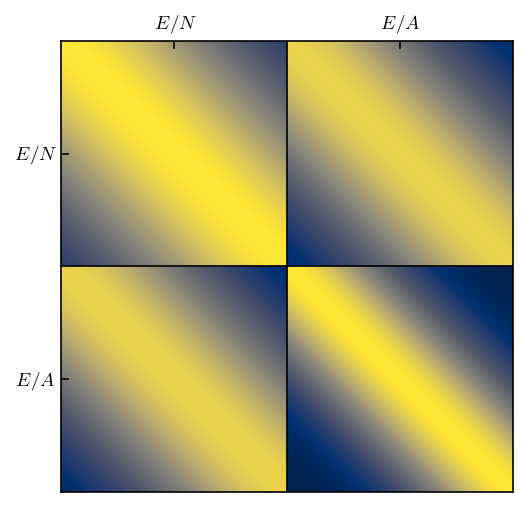

In [127]:
plot_cross_covariance(x_test, cov_test)

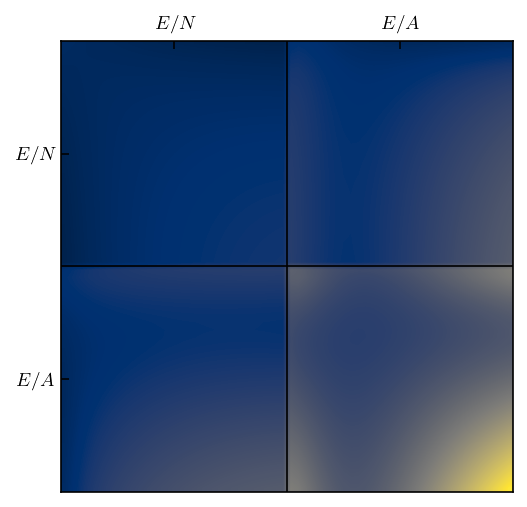

In [56]:
plot_cross_covariance(density, cov_ns_full)

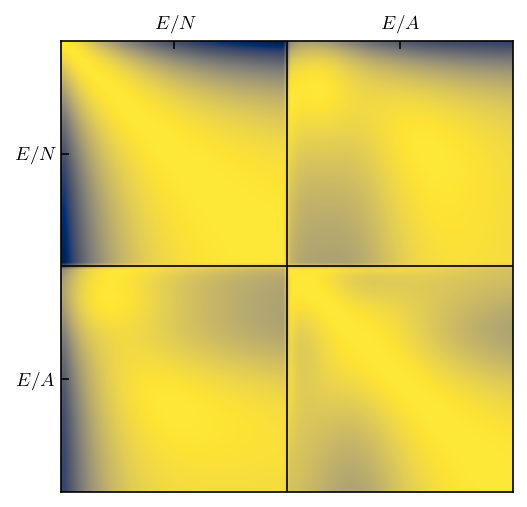

In [57]:
plot_cross_covariance(density, cov_ns_full_norm)

In [ ]:
for kf_type_, kf_i in zip(['kf-sym', 'kf-pure', 'kf-avg'], [kf_s, kf_n, (kf_s+kf_n)/2.]):
    
    Q_d_i = ratio_kf(kf_i[:, None], breakdown=Lb)
    ref_d_3bf_i = 16 * kf_i**3
    coeffs_d_2_plus_3bf_i = gm.coefficients(y_d_2_plus_3bf, Q_d_i, ref_2bf, orders=orders)
    coeffs_d_2bf_i = gm.coefficients(y_d_2bf, Q_d_i, ref_2bf, orders=orders)
    coeffs_d_3bf_i = gm.coefficients(y_d_3bf, Q_d_i, ref_d_3bf_i, orders=orders)
    
    fig, axes = plot_coefficients(
        kf_i, density, coeffs_2bf=coeffs_d_2bf_i, coeffs_3bf=coeffs_d_3bf_i,
        coeffs_23bf=coeffs_d_2_plus_3bf_i, orders=orders, colors=colors)

    fig.suptitle(f'Symmetry Energy: {kf_type_}', y=1.02)
    fig.savefig(f'coeffs_symmetry_energy_compare_2bf_3bf_{kf_type_}')

## Convergence Analysis

In [ ]:
def ref_cubic_3bf(X):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * X.ravel() ** 3

def ref_linear_3bf(X):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * X.ravel()


ref_3bf_func = ref_linear_3bf

This is not quite right: should put the 3BF corrections right after the 2BF corrections

In [ ]:
# def create_appended_y(y2, y3, y2_ref, y3_ref):
#     y2 = y2.copy()
#     diff = y2[:, [-1]] + y2_ref * y3[:, 2:] / y3_ref
#     return np.append(y2, diff, axis=1)

In [ ]:
# y_n_app = create_appended_y(y_n_2bf, y_n_3bf, ref_2bf, ref_3bf_func(kf_n)[:, None])
# y_s_app = create_appended_y(y_s_2bf, y_s_3bf, ref_2bf, ref_3bf_func(kf_s)[:, None])
# y_d_app = create_appended_y(y_d_2bf, y_d_3bf, ref_2bf, ref_3bf_func(kf_avg)[:, None])

In [ ]:
c_n_app = gm.coefficients(y_n_appended, Q_n, ref_2bf, orders=orders_appended)
c_s_app = gm.coefficients(y_s_appended, Q_s, ref_2bf, orders=orders_appended)
c_d_app = gm.coefficients(y_d_appended, Q_d, ref_2bf, orders=orders_appended)

In [ ]:
fig, axes = plot_coefficients(
    kf_n, density, coeffs_2bf=coeffs_n_2bf, coeffs_3bf=coeffs_n_3bf,
    coeffs_23bf=coeffs_n_2_plus_3bf, orders=orders, colors=colors)
fig.suptitle('Pure Neutron Matter', y=1.02)

In [ ]:
plt.plot(kf_n, c_s_app);
plt.axhline(0, 0, 1)

In [ ]:
kf_n * hbar_c

In [ ]:
0.12, 3.2

In [ ]:
density

In [ ]:
nuclear_density(600 / hbar_c, 2)

In [ ]:
nuclear_density(600 / hbar_c, 4)

In [ ]:
assert False

In [ ]:
fermi_momenta = {
    pure_neutron: kf_n,
    sym_nuclear: kf_s,
    s2_energy: kf_d
}

Fermi_momenta = {
    pure_neutron: Kf_n,
    sym_nuclear: Kf_s,
    s2_energy: Kf_d
}

refs = {
    # E/N
    (pure_neutron, body2): ref_2bf,
    (pure_neutron, body3): ref_3bf_func,
    (pure_neutron, body23): ref_2bf,
    (pure_neutron, body23_appended): ref_2bf,
    # E/A
    (sym_nuclear, body2): ref_2bf,
    (sym_nuclear, body3): ref_3bf_func,
    (sym_nuclear, body23): ref_2bf,
    (sym_nuclear, body23_appended): ref_2bf,
    # S2
    (s2_energy, body2): ref_2bf,
    (s2_energy, body3): ref_3bf_func,
    (s2_energy, body23): ref_2bf,
    (s2_energy, body23_appended): ref_2bf,
}

# S2_observables = {
#     body2: y_d_2bf,
#     body3: y_d_3bf,
#     body23: y_d_2_plus_3bf,
# }
observables = {
    # E/N
    (pure_neutron, body2): y_n_2bf,
    (pure_neutron, body3): y_n_3bf,
    (pure_neutron, body23): y_n_2_plus_3bf,
#     (pure_neutron, body23_appended): y_n_app,
    (pure_neutron, body23_appended): y_n_appended,
    # E/A
    (sym_nuclear, body2): y_s_2bf,
    (sym_nuclear, body3): y_s_3bf,
    (sym_nuclear, body23): y_s_2_plus_3bf,
#     (sym_nuclear, body23_appended): y_s_app,
    (sym_nuclear, body23_appended): y_s_appended,
    # S2
    (s2_energy, body2): y_d_2bf,
    (s2_energy, body3): y_d_3bf,
    (s2_energy, body23): y_d_2_plus_3bf,
#     (s2_energy, body23_appended): y_d_app,
#     (s2_energy, body23_appended): y_d_appended,
}

excluded_orders = {
    body2: excluded_2bf,
    body3: excluded_3bf,
    body23: excluded_2bf,
    body23_appended: excluded_2bf,
}

obs_types = [pure_neutron, sym_nuclear, s2_energy]
systems = {pure_neutron: 'neutron', sym_nuclear: 'symmetric', s2_energy: 'difference'}
body_types = [body2, body3, body23, body23_appended]

In [ ]:
analyses = {}

with tqdm(total=len(obs_types) * len(body_types)) as pbar:
    for obs_type in obs_types:
        X_i = Fermi_momenta[obs_type]
        y2_i = observables[obs_type, body2]
        y3_i = observables[obs_type, body23]
        ref2_i = refs[obs_type, body2]
        ref3_i = refs[obs_type, body3]
        for n_body in body_types:
            pbar.set_postfix(obs_type=obs_type, n_body=n_body, refresh=True)
            ex_i = excluded_orders[n_body]
            system_i = systems[obs_type]
            orders_i = orders.copy()

            if n_body == body23_appended:
                max_idxs = [3, 5]
                max_idx_labels = [2, 3]
#                 orders_i = orders_appended
            else:
                max_idxs = [2, 3]
                max_idx_labels = None
#                 orders_i = orders

            analyses[obs_type, n_body] = MatterConvergenceAnalysis(
                X=X_i, y2=y2_i, y3=y3_i, orders=orders_i, train=train, valid=valid,
                ref2=ref2_i, ref3=ref3_i, ratio='kf', density=density,
                kernel=kernel, system=system_i, fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
                body=n_body, savefigs=savefigs, excluded=ex_i,
#                 optimizer=optimizer,
                decomposition='eig', **hyperparams
            )

            analyses[obs_type, n_body].setup_posteriors(
                breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
                ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
                max_idx=max_idxs, logprior=None, max_idx_labels=max_idx_labels
            )
            pbar.update(1)

In [ ]:
analyses[sym_nuclear, body23_appended].plot_coefficients(show_excluded=True, show_process=True, breakdown=Lb)

In [ ]:
analyses[sym_nuclear, body23_appended].plot_coeff_diagnostics(breakdown=Lb);

In [ ]:
analyses[pure_neutron, body23_appended].plot_coeff_diagnostics(breakdown=Lb);

In [ ]:
analyses[s2_energy, body23_appended].plot_coeff_diagnostics(breakdown=Lb);

In [ ]:
analyses[sym_nuclear, body23_appended].plot_observables(show_excluded=True, show_process=True, breakdown=Lb)

In [ ]:
assert False

In [ ]:
def create_breakdown_df(analyses, body_types, obs_type):
    df_Lb_pdfs = pd.concat([analyses[obs_type, n_body].df_breakdown for n_body in body_types])
#     df_Lb_pdfs['$k_F$'] = kf_type_name
    grouped = df_Lb_pdfs[(df_Lb_pdfs['Body'] != body23) & (df_Lb_pdfs['Body'] != body23_appended)].groupby(
        ['$\Lambda_b$ (MeV)', 'Order', 'system'], sort=False
    )
    prod_df = grouped.prod().reset_index()
    prod_df['Body'] = 'Total'
    
    new_df = pd.concat([df_Lb_pdfs, prod_df], sort=False)
    # For appended 3N orders
#     order_fixes = {'N$^4$LO': 'N$^2$LO', 'N$^5$LO': 'N$^3$LO'}
#     new_df['Order'] = new_df['Order'].replace(order_fixes)
    
    return new_df

In [ ]:
df_Lb_pdfs_n = create_breakdown_df(analyses, body_types, pure_neutron)
df_Lb_pdfs_s = create_breakdown_df(analyses, body_types, sym_nuclear)
df_Lb_pdfs_d = create_breakdown_df(analyses, body_types, s2_energy)


df_Lb_pdf = pd.concat([df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_d])


for obs_type, df_lb_i in zip(obs_types, [df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_d]):
    fig, ax = plt.subplots(figsize=(3.4, 4.4))
    ax = pdfplot(
        x=r'$\Lambda_b$ (MeV)', y='Body', pdf='pdf', data=df_lb_i, hue='Order',
        order=[*body_types[:-1], 'Total', body_types[-1]],
        hue_order=[r'N$^2$LO', r'N$^3$LO'],
        cut=1e-2, linewidth=1,
            palette="coolwarm", saturation=1., ax=ax, margin=0.3,
    )
    ax.set_xlim(0, 1200)
    ax.set_xticks([0, 300, 600, 900, 1200])
    ax.grid(axis='x')
    ax.set_title(f'{obs_type}')
    ax.set_axisbelow(True)
    plt.show()
#     fig.savefig(f'breakdown_obs-{obs_type}')

In [ ]:
savefigs_diagnostics = True

In [ ]:
df_Lb_pdf_all = df_Lb_pdfs_n.copy()
df_Lb_pdf_all['pdf'] = df_Lb_pdfs_n['pdf'] * df_Lb_pdfs_s['pdf'] * df_Lb_pdfs_d['pdf']
df_Lb_pdf_all['system'] = 'All'
df_Lb_pdf = pd.concat([df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_d, df_Lb_pdf_all])

fig, ax = plt.subplots(figsize=(3.4, 4.4))
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf[df_Lb_pdf['Body'] == 'Total'], hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
    palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
# ax.set_title(f'{obs_type}')
ax.set_axisbelow(True)
plt.show()
if savefigs_diagnostics:
    fig.savefig(f'breakdown_2n-3n-product_Lambda_{Lambda}')

In [ ]:
df_Lb_pdf_all = df_Lb_pdfs_n.copy()
df_Lb_pdf_all['pdf'] = df_Lb_pdfs_n['pdf'] * df_Lb_pdfs_s['pdf'] * df_Lb_pdfs_d['pdf']
df_Lb_pdf_all['system'] = 'All'
df_Lb_pdf = pd.concat([df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_d, df_Lb_pdf_all])

fig, ax = plt.subplots(figsize=(3.4, 4.4))
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf[df_Lb_pdf['Body'] == 'Total'], hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
    palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
# ax.set_title(f'{obs_type}')
ax.set_axisbelow(True)
plt.show()
if savefigs_diagnostics:
    fig.savefig(f'breakdown_2n-3n-product_Lambda_{Lambda}')

In [ ]:
fig, ax = plt.subplots(figsize=(3.4, 4.4))
ax = pdfplot(
    x=r'$\Lambda_b$ (MeV)', y='system', pdf='pdf', data=df_Lb_pdf[df_Lb_pdf['Body'] == 'Appended'], hue='Order',
    order=[r'$E/N$', r'$E/A$', r'$S_2$', 'All'], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
    palette="coolwarm", saturation=1., ax=ax, margin=0.3,
)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.grid(axis='x')
# ax.set_title(f'{obs_type}')
ax.set_axisbelow(True)
plt.show()
if savefigs_diagnostics:
    fig.savefig(f'breakdown_3n-appended_Lambda_{Lambda}')

In [ ]:
lb_max_mask = \
    (df_Lb_pdf['Body'] == 'Appended') & \
    (df_Lb_pdf['system'] == 'All') & \
    (df_Lb_pdf['Order'] == 'N$^3$LO')
lb_max_idx = df_Lb_pdf[lb_max_mask]['pdf'].idxmax()
lb_map = df_Lb_pdf[lb_max_mask].loc[lb_max_idx]['$\Lambda_b$ (MeV)']

In [ ]:
lb_map

In [ ]:
lb_max_s_mask = \
    (df_Lb_pdf['Body'] == 'Appended') & \
    (df_Lb_pdf['system'] == '$E/A$') & \
    (df_Lb_pdf['Order'] == 'N$^3$LO')
lb_max_idx_s = df_Lb_pdf[lb_max_s_mask]['pdf'].idxmax()
lb_map_s = df_Lb_pdf[lb_max_s_mask].loc[lb_max_idx_s]['$\Lambda_b$ (MeV)']

In [ ]:
lb_map_s

In [ ]:
analyses[s2_energy, body23_appended].df_joint

In [ ]:
ls_map_vals = {}
for obs_type, n_body in product(obs_types, body_types):
#     fig, ax = plt.subplots()
    print(f'obs: {obs_type}, Body: {n_body}')
    if n_body == body23_appended:
        midx = 3
        ls_map_i = analyses[obs_type, n_body].compute_best_length_scale_for_breakdown(lb_map, midx)
        ls_map_vals[obs_type] = ls_map_i
        print(ls_map_i)
    else:
        midx = 3
    fig = analyses[obs_type, n_body].plot_joint_breakdown_ls(max_idx=midx)
    fig.suptitle(f'{obs_type}, {n_body}', y=3)
    plt.show()

In [ ]:
Q_n_map = ratio_kf(kf_n, breakdown=lb_map)
Q_s_map = ratio_kf(kf_s, breakdown=lb_map)
Q_d_map = ratio_kf(kf_d, breakdown=lb_map)

In [ ]:
coeffs_n_appended_map = gm.coefficients(y_n_appended, ratio=Q_n_map, ref=ref_2bf, orders=orders_appended)
coeffs_s_appended_map = gm.coefficients(y_s_appended, ratio=Q_s_map, ref=ref_2bf, orders=orders_appended)
coeffs_d_appended_map = gm.coefficients(y_d_appended, ratio=Q_d_map, ref=ref_2bf, orders=orders_appended)

In [ ]:
hyperparams

In [ ]:
order_labels_appended = [fr'$c_{{{n}}}^{{({b})}}$' for n, b in zip(orders_appended, [2, 2, 2, 3, 2, 3])]

In [ ]:
cmap_list_names_appended = ['Oranges', 'Greens', 'Blues', 'Blues', 'Reds', 'Reds']
cmap_list_appended = [plt.get_cmap(c) for c in cmap_list_names_appended]
color_list_appended = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmap_list_appended)]

In [ ]:
order_labels_appended

In [ ]:
from nuclear_matter.graphs import lighten_color

In [ ]:
def diagnostics_for_2bf_and_3bf(X, c, orders, train, valid, order_labels, colors, density, **kwargs):
    gp = gm.ConjugateGaussianProcess(**kwargs)
    gp.fit(X[train], c[train])
    cov = gp.cov(X[valid])
    print(gp.cbar_sq_mean_, gp.kernel_)
    gp_std = gp.cbar_sq_mean_
    interp_c, interp_std = gp.predict(X, return_std=True)
    mean = np.zeros(cov.shape[0])
    
    fig = plt.figure(figsize=(7.0, 2.5), constrained_layout=True)
    spec = fig.add_gridspec(nrows=1, ncols=7)
    ax_cs = fig.add_subplot(spec[:, :3])
    ax_md = fig.add_subplot(spec[:, 3])
    ax_pc = fig.add_subplot(spec[:, 4:])
    
#     markeredgecolors = [None, None, None, '0.3', None, '0.3']
    markeredgecolors = colors
#     markerlinestyles = ['-', '-', '-', '--', '-', '--']
    markerlinestyles = ['-', '-', '-', '-', '-', '-']
    markerfillstyles = ['full', 'full', 'full', 'left', 'full', 'left']
    markers = ['^', 'X', 'o', 'o',  's', 's']
    markerfacecolors = colors
    markerfacecoloralts = np.array(colors).copy()
    markerfacecoloralts[3] = mpl.colors.to_rgba('w')
    markerfacecoloralts[5] = mpl.colors.to_rgba('w')
    
    i = 0
#     x = X.ravel()
    x = density
    for n, c_n, label, color, ec, ls in zip(orders, c.T, order_labels, colors, markeredgecolors, markerlinestyles):
        ax_cs.plot(
            x, c_n, c=color, label=label, ls=ls, zorder=i/10, markevery=train, marker=markers[i],
            markeredgecolor=ec, fillstyle=markerfillstyles[i], markerfacecoloralt=markerfacecoloralts[i],
            markeredgewidth=0.5,
        )
        light_color = lighten_color(color)
        ax_cs.fill_between(
            x, interp_c[:, i] + 2*interp_std, interp_c[:, i] - 2*interp_std,
            facecolor=light_color, edgecolor=color, zorder=(i-0.5)/10, alpha=1
        )
#         ax_cs.scatter(
#             X[train].ravel(), c_n[train], c=color, edgecolor=ec, linestyle=ls,
#             linewidth=0.5, zorder=(i+0.5)/10
#         )
        ax_cs.axhline(0, 0, 1, c='k', lw=0.8, zorder=-1)
        ax_cs.axhline(+2*gp_std, 0, 1, c='lightgrey', lw=0.8, zorder=-1)
        ax_cs.axhline(-2*gp_std, 0, 1, c='lightgrey', lw=0.8, zorder=-1)
        i += 1
#     ax_cs.set_xlabel(r'$k_F$ [fm$^{-1}$]')
    ax_cs.set_xlabel(r'$n$ [fm$^{-3}$]')
    ax_cs.set_xticks(x[train], minor=False)
    ax_cs.set_xticks(x[valid], minor=True)
    ax_cs.legend(ncol=3)
    
    graph = gm.GraphicalDiagnostic(
        c[valid], mean=mean, cov=cov, markeredgecolors=markeredgecolors,
        colors=colors, markerfillstyles=markerfillstyles, markers=markers
    )
    graph.md_squared(type='box', trim=True, title=None, ax=ax_md)
    graph.pivoted_cholesky_errors(ax=ax_pc)
    
    bbox = dict(facecolor='w', boxstyle='round', alpha=0.7)
    ax_pc.text(0.05, 0.95, r'${\rm D}_{\rm PC}$', ha='left', va='top', bbox=bbox, transform=ax_pc.transAxes)
    ax_pc.set_title('')
    from matplotlib.ticker import MaxNLocator
    ax_pc.yaxis.set_major_locator(MaxNLocator(integer=True))
    return fig


def plot_cbar_ell_correlation(X, c, orders, train, ls_vals, **kwargs):
    gp = gm.ConjugateGaussianProcess(**kwargs)
    gp.fit(X[train], c[train])
    loglike = np.array([gp.log_marginal_likelihood(theta=np.log(ls)) for ls in ls_vals])
    

In [ ]:
coeff_noise_n = 1e-2
coeff_noise_s = 1e-2
coeff_noise_d = 1e-2

valid2 = [i % 4 != 0 for i in range(len(density))]

In [ ]:
hyperparams

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig = diagnostics_for_2bf_and_3bf(
        Kf_n, coeffs_n_appended, orders_appended, train, valid2, order_labels_appended,
        colors=color_list_appended, density=density,
        kernel=RBF(ls_map_vals[pure_neutron]) + WhiteKernel(coeff_noise_n**2, noise_level_bounds='fixed'),
        decomposition='eig',
#         decomposition='cholesky',
#         kernel=RBF(0.9) + WhiteKernel(coeff_noise**2, noise_level_bounds='fixed'),
#         optimizer=None,
        **hyperparams
#         center=0, disp=0, sd=0.5
    );
    plt.show()
    if savefigs_diagnostics:
        fig.savefig(f'diagnostics_3n-appended_system-n_Lambda_{Lambda}')

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig = diagnostics_for_2bf_and_3bf(
        Kf_s, coeffs_s_appended, orders_appended, train, valid, order_labels_appended,
        colors=color_list_appended, density=density,
        kernel=RBF(ls_map_vals[sym_nuclear]/2) + WhiteKernel(coeff_noise_s**2, noise_level_bounds='fixed'),
        decomposition='eig',
#         decomposition='cholesky',
#         optimizer=None,
        **hyperparams
    )
    plt.show()
    if savefigs_diagnostics:
        fig.savefig(f'diagnostics_3n-appended_system-s_Lambda_{Lambda}')

In [ ]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig = diagnostics_for_2bf_and_3bf(
        Kf_d, coeffs_d_appended, orders_appended, train, valid, order_labels_appended,
        colors=color_list_appended, density=density,
        kernel=RBF(ls_map_vals[s2_energy]) + WhiteKernel(coeff_noise_d**2, noise_level_bounds='fixed'),
        decomposition='eig',
#         decomposition='cholesky',
#         optimizer=None,
        **hyperparams
    )
    plt.show()
    if savefigs_diagnostics:
        fig.savefig(f'diagnostics_3n-appended_system-d_Lambda_{Lambda}')